## Imports

In [1]:
from healnet.models import HealNet
from healnet.etl import MMDataset
import torch
import einops
from torch.utils.data import Dataset, DataLoader
from typing import *

%load_ext autoreload
%autoreload 2

In [30]:
import os
import torch
import pandas as pd
import h5py
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, df, img_features_path, scaler=None):
        self.df = df.reset_index(drop=True)
        self.img_features_path = img_features_path
        self.tabular_columns = [col for col in df.columns if col.startswith('cnv')]

        self.scaler = scaler
        
        if self.scaler is not None:
            # Ensure the scaler has been fitted
            if not hasattr(self.scaler, 'mean_') or not hasattr(self.scaler, 'scale_'):
                raise ValueError("Scaler must be fitted before being passed to the dataset.")
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Extract row data
        row = self.df.iloc[idx]
        wsi_file_name = row["wsi_file_name"][:-5]  # Adjust as needed
        target_label = row["progressor_status"]
        
        # Convert target label from 'NP'/'P' to 0/1
        if target_label == 'P':
            target = 1
        else:
            target = 0
        
        # Load tabular features
        tabular_features = row[self.tabular_columns].values.astype('float32')
        if self.scaler:
            # Apply scaling
            tabular_features = self.scaler.transform([tabular_features])[0]
        tabular_tensor = torch.tensor(tabular_features, dtype=torch.float32)
        
        # Load image features from .h5 file
        img_features_file = os.path.join(self.img_features_path, wsi_file_name + ".h5")
        with h5py.File(img_features_file, 'r') as h5_file:
            # Extract 'cluster_features' dataset
            if "cluster_features" in h5_file:
                cluster_features = h5_file["cluster_features"][:]
            else:
                raise KeyError(f"'cluster_features' not found in {img_features_file}")
            
        # Convert cluster features to a tensor
        img_features_tensor = torch.tensor(cluster_features, dtype=torch.float32)
        
        # Prepare the target tensor
        target_tensor = torch.tensor(target, dtype=torch.float32)
        
        return {
            'tabular': tabular_tensor,
            'image': img_features_tensor,
            'target': target_tensor
        }

# Paths to your data
path_to_img_features = "/scratchc/fmlab/zuberi01/masters/saved_patches/40x_400/features2/h5_files/"
path_to_csv = "/scratchc/fmlab/zuberi01/phd/sequoia-pub/examples/matching_rows_sequoia.csv"

# Load the CSV file
df = pd.read_csv(path_to_csv)

# Split the DataFrame into train, val, and test sets
train_df = df[df["split_0"] == "train"]
val_df = df[df["split_0"] == "val"]
test_df = df[df["split_0"] == "test"]

from sklearn.preprocessing import StandardScaler

# Identify tabular columns
tabular_columns = [col for col in df.columns if col.startswith('cnv')]
# Initialize the scaler
scaler = StandardScaler()
# Fit the scaler on the training data
scaler.fit(train_df[tabular_columns])

# Create datasets for each split
train_dataset = CustomDataset(train_df, path_to_img_features, scaler=scaler)
val_dataset = CustomDataset(val_df, path_to_img_features, scaler=scaler)
test_dataset = CustomDataset(test_df, path_to_img_features, scaler=scaler)

# Define loader arguments
loader_args = {
    "batch_size": 4,  # Adjust batch size as needed
    "shuffle": True, 
    "num_workers": 8, 
    "pin_memory": True, 
    "multiprocessing_context": "fork", 
    "persistent_workers": True, 
}

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, **loader_args)
val_loader = DataLoader(val_dataset, **loader_args)
test_loader = DataLoader(test_dataset, **loader_args)

# ------------------ Data Validation Tests ------------------

def validate_datasets(train_loader, val_loader, test_loader):
    print("----- Dataset Sizes -----")
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}\n")
    
    # Function to validate a single batch
    def validate_batch(batch, split_name):
        tabular = batch['tabular']
        image = batch['image']
        target = batch['target']
        
        print(f"--- {split_name} Batch ---")
        print(f"Tabular data shape: {tabular.shape}")  # Expected: (batch_size, tabular_features)
        print(f"Image data shape: {image.shape}")      # Depends on your image feature dimensions
        print(f"Target shape: {target.shape}")        # Expected: (batch_size,)
        
        print(f"Tabular data type: {tabular.dtype}")
        print(f"Image data type: {image.dtype}")
        print(f"Target data type: {target.dtype}\n")
        
        # Optionally, visualize the first image in the batch
        # Uncomment the following lines if image data is suitable for visualization
        """
        if image.ndim == 3:  # Assuming image shape is (batch_size, channels, features)
            img = image[0].numpy()
            plt.imshow(img, cmap='gray')
            plt.title(f"{split_name} Sample Image")
            plt.show()
        """

    # Get one batch from each DataLoader
    train_batch = next(iter(train_loader))
    val_batch = next(iter(val_loader))
    test_batch = next(iter(test_loader))
    
    validate_batch(train_batch, "Train")
    validate_batch(val_batch, "Validation")
    validate_batch(test_batch, "Test")

# Run the validation
validate_datasets(train_loader, val_loader, test_loader)


----- Dataset Sizes -----
Train samples: 440
Validation samples: 67
Test samples: 48



/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted w

--- Train Batch ---
Tabular data shape: torch.Size([4, 561])
Image data shape: torch.Size([4, 100, 1024])
Target shape: torch.Size([4])
Tabular data type: torch.float32
Image data type: torch.float32
Target data type: torch.float32

--- Validation Batch ---
Tabular data shape: torch.Size([4, 561])
Image data shape: torch.Size([4, 100, 1024])
Target shape: torch.Size([4])
Tabular data type: torch.float32
Image data type: torch.float32
Target data type: torch.float32

--- Test Batch ---
Tabular data shape: torch.Size([4, 561])
Image data shape: torch.Size([4, 100, 1024])
Target shape: torch.Size([4])
Tabular data type: torch.float32
Image data type: torch.float32
Target data type: torch.float32



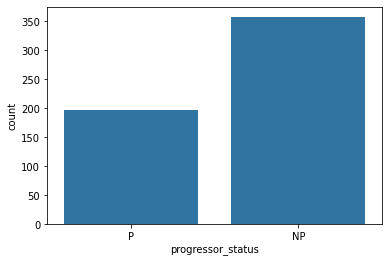

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='progressor_status', data=df)
plt.show()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[tabular_columns] = scaler.fit_transform(df[tabular_columns])

In [ ]:
# ------------------ Model Training ------------------

from healnet.models.healnet import HealNet  # Adjust import path as necessary
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bars

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the number of classes
num_classes = 2  # Adjust based on your dataset

# Inspect the shape of image features to set input dimensions
# Assuming all image features have the same shape
sample_image = train_dataset[0]['image']
print(f"Sample image shape: {sample_image.shape}")  # Example: (channels, features)

# Example: If cluster_features have shape (channels, features), you might need to flatten or process them
# Adjust HealNet parameters accordingly

# Determine input dimensions
# For tabular data
tabular_features = train_dataset[0]['tabular'].shape[0]  # 5000 as per your data

# For image data
# Assuming image features are 1D vectors per sample; adjust if different
image_features = train_dataset[0]['image'].shape[0]  # Number of image feature channels
# If image features are multi-dimensional, adjust input_axes and potentially the model architecture

# Instantiate the HealNet model with corrected input_axes and input_channels
model = HealNet(
    modalities=2, 
    input_channels=[1, 100],  # 1 for tabular, 100 for image features
    input_axes=[1, 2],        # 1 axis for tabular, 2 axes for image features
    num_classes=num_classes,
    # Add other parameters as required by your model configuration
).to(device)

print('tabular_features', tabular_features)
print('image_features', image_features)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training parameters
num_epochs = 20  # Adjust based on your needs
best_val_loss = float('inf')
patience = 5
counter = 0

# Training and Validation Loop
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    
    # ------------------ Training Phase ------------------
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    # Example usage: iterate over the training data
    for batch_idx, batch in enumerate(train_loader):

        # print the batch index
        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx + 1}: {len(train_loader)}")

        tabular_data = batch['tabular'].to(device)  # Shape: (batch_size, tabular_features)
        image_data = batch['image'].to(device)      # Shape: (batch_size, channels, features)
        targets = batch['target'].long().to(device) # Shape: (batch_size,)
        
        # Debug: Print shapes
        #print(f"Batch {batch_idx + 1}:")
        #print(f"Tabular Data Shape: {tabular_data.shape}")  # Expected: (batch_size, tabular_features)
        #print(f"Image Data Shape: {image_data.shape}")      # Expected: (batch_size, channels, features)
        #print(f"Targets Shape: {targets.shape}")            # Expected: (batch_size,)
        
        # Forward pass
        #print('x')
        outputs = model([tabular_data, image_data])  # Shape: (batch_size, num_classes)
        
        # Compute loss
        loss = criterion(outputs, targets)
        train_loss += loss.item() * tabular_data.size(0)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    
    # ------------------ Validation Phase ------------------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            tabular_data = batch['tabular'].to(device)
            image_data = batch['image'].to(device)
            targets = batch['target'].long().to(device)

            outputs = model([tabular_data, image_data])
            loss = criterion(outputs, targets)
            val_loss += loss.item() * tabular_data.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
    # ------------------ Checkpointing ------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_healnet_model.pth')
        print("✅ Model saved!")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Step the scheduler
    scheduler.step()

# ------------------ Testing Phase ------------------

# Load the best model
model.load_state_dict(torch.load('best_healnet_model.pth'))
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        tabular_data = batch['tabular'].to(device)
        image_data = batch['image'].to(device)
        targets = batch['target'].long().to(device)
        
        outputs = model([tabular_data, image_data])
        loss = criterion(outputs, targets)
        test_loss += loss.item() * tabular_data.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")


Using device: cpu
Sample image shape: torch.Size([100, 1024])


/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zuberi01/miniforge3/envs/healnetenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted w

tabular_features 561
image_features 100
Epoch 1/20
Batch 1: 110
Batch 51: 110
Batch 101: 110


Train Loss: 1.2498 | Train Acc: 59.77%
Val Loss: 0.7941 | Val Acc: 61.19%
✅ Model saved!
Epoch 2/20
Batch 1: 110
Batch 51: 110
Batch 101: 110


Train Loss: 1.3360 | Train Acc: 53.86%
Val Loss: 2.5005 | Val Acc: 61.19%
No improvement. Counter: 1/5
Epoch 3/20
Batch 1: 110
Batch 51: 110
Batch 101: 110


Train Loss: 1.9355 | Train Acc: 47.50%
Val Loss: 1.8223 | Val Acc: 38.81%
No improvement. Counter: 2/5
Epoch 4/20
Batch 1: 110
Batch 51: 110
Batch 101: 110


Train Loss: 2.2548 | Train Acc: 60.23%
Val Loss: 3.7767 | Val Acc: 61.19%
No improvement. Counter: 3/5
Epoch 5/20
Batch 1: 110
Batch 51: 110


## Synthetic modalities

We instantiate a synthetic multimodal dataset for demo purposes. 

In [16]:
import os
import torch
import pandas as pd
import h5py
from torch.utils.data import Dataset, DataLoader

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, df, img_features_path):
        self.df = df.reset_index(drop=True)
        self.img_features_path = img_features_path
        self.tabular_columns = [col for col in df.columns if col.startswith('cnv')]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Extract row data
        row = self.df.iloc[idx]
        wsi_file_name = row["wsi_file_name"][:-5]  # Adjust as needed
        target_label = row["progressor_status"]
        
        # Convert target label from 'NP'/'P' to 0/1
        if target_label == 'P':
            target = 1
        else:
            target = 0
        
        # Load tabular features
        tabular_features = row[self.tabular_columns].values.astype('float32')
        tabular_tensor = torch.tensor(tabular_features)
        
        # Load image features from .h5 file
        img_features_file = os.path.join(self.img_features_path, wsi_file_name + ".h5")
        with h5py.File(img_features_file, 'r') as h5_file:
            # Extract 'cluster_features' dataset
            if "cluster_features" in h5_file:
                cluster_features = h5_file["cluster_features"][:]
            else:
                raise KeyError(f"'cluster_features' not found in {img_features_file}")
            
        # Convert cluster features to a tensor
        img_features_tensor = torch.tensor(cluster_features, dtype=torch.float32)
        
        # Prepare the target tensor
        target_tensor = torch.tensor(target, dtype=torch.float32)
        
        return {
            'tabular': tabular_tensor,
            'image': img_features_tensor,
            'target': target_tensor
        }

# Paths to your data
path_to_img_features = "/scratchc/fmlab/zuberi01/masters/saved_patches/40x_400/features2/h5_files/"
path_to_csv = "/scratchc/fmlab/zuberi01/phd/sequoia-pub/examples/matching_rows_sequoia.csv"

# Load the CSV file
df = pd.read_csv(path_to_csv)

# Split the DataFrame into train, val, and test sets
train_df = df[df["split_0"] == "train"]
val_df = df[df["split_0"] == "val"]
test_df = df[df["split_0"] == "test"]

# Create datasets for each split
train_dataset = CustomDataset(train_df, path_to_img_features)
val_dataset = CustomDataset(val_df, path_to_img_features)
test_dataset = CustomDataset(test_df, path_to_img_features)

# Define loader arguments
loader_args = {
    "batch_size": 4,  # Adjust batch size as needed
    "shuffle": True, 
    "num_workers": 8, 
    "pin_memory": True, 
    "multiprocessing_context": "fork", 
    "persistent_workers": True, 
}

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, **loader_args)
val_loader = DataLoader(val_dataset, **loader_args)
test_loader = DataLoader(test_dataset, **loader_args)

# Example usage: iterate over the training data
for batch in train_loader:
    tabular_data = batch['tabular']
    image_data = batch['image']
    targets = batch['target']
    
    # Now you can feed tabular_data and image_data into your model
    # For example:
    # outputs = model(tabular_data, image_data)
    # loss = loss_fn(outputs, targets)
    # ... (rest of your training loop)


In [37]:
# Import the HealNet class
from healnet.models.healnet import HealNet

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of classes
num_classes = 2  # Adjust based on your dataset

# Instantiate the HealNet model
model = HealNet(
    modalities=2, 
    input_channels=[1, 1],  # Number of channels per modality
    input_axes=[1, 2],       # Updated to match the number of axes per modality
    num_classes=num_classes,
    # Add other parameters as required by your model configuration
).to(device)


In [40]:
def check_input_axes(inputs, expected_axes):
    """
    Checks if each input modality has the expected number of axes.

    Parameters:
    - inputs (list of torch.Tensor): The input tensors for each modality.
    - expected_axes (list of int): The expected number of axes for each modality.

    Raises:
    - AssertionError: If any modality does not have the expected number of axes.
    """
    for i, (tensor, expected) in enumerate(zip(inputs, expected_axes), 1):
        # Exclude the batch dimension
        actual_axes = tensor.dim() - 2  # Assuming [batch, channels, ...]
        assert actual_axes == expected, (
            f"Input data for modality {i} has {actual_axes} axes, "
            f"but expected {expected} axes."
        )
    print("All input modalities have the correct number of axes.")


import torch

# Sample shapes based on your error
# Tabular Data: [batch_size, channels, num_tabular_features] => [4, 1, 561]
tabular_data = torch.rand(4, 1, 561)

# Image Data: [batch_size, channels, height, width] => [4, 1, 100, 1024]
image_data = torch.rand(4, 1, 100, 1024)

# Combine into a list
inputs = [tabular_data, image_data]

# Define expected axes
expected_axes = [1, 2]


try:
    check_input_axes(inputs, expected_axes)
except AssertionError as e:
    print(f"AssertionError: {e}")

All input modalities have the correct number of axes.


In [50]:
for batch_idx, batch in enumerate(tqdm(train_loader)):
    # Retrieve data and move to device
    tabular_data = batch['tabular'].to(device).unsqueeze(1)  # Shape: [batch_size, 1, num_tabular_features]
    image_data = batch['image'].to(device).unsqueeze(1)      # Shape: [batch_size, 1, num_image_features]
    targets = batch['target'].long().to(device) 

    # print their shapes
    print(tabular_data.shape)
    print(image_data.shape)
    print(targets.shape)

    # break after printing the first three
    if batch_idx == 3:
        break

  3%|▎         | 3/110 [00:00<00:01, 83.97it/s]

torch.Size([4, 1, 561])
torch.Size([4, 1, 100, 1024])
torch.Size([4])
torch.Size([4, 1, 561])
torch.Size([4, 1, 100, 1024])
torch.Size([4])
torch.Size([4, 1, 561])
torch.Size([4, 1, 100, 1024])
torch.Size([4])
torch.Size([4, 1, 561])
torch.Size([4, 1, 100, 1024])
torch.Size([4])


In [62]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from healnet.models.healnet import HealNet

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the number of classes
num_classes = 2  # Adjust based on your dataset

# Instantiate the HealNet model with updated input_axes
model = HealNet(
    modalities=2, 
    input_channels=[1, 1],  # Number of channels per modality
    input_axes=[1, 2],       # Updated to match the number of axes per modality
    num_classes=num_classes,
    # Add other parameters as required by your model configuration
).to(device)

print("HealNet model instantiated successfully.")

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
num_epochs = 10  # Adjust as needed

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        # Retrieve data and move to device
        tabular_data = batch['tabular'].to(device).unsqueeze(1)  # Shape: [batch_size, 1, num_tabular_features]
        image_data = batch['image'].to(device).unsqueeze(1)      # Shape: [batch_size, 1, num_image_features]
        targets = batch['target'].long().to(device)             # Shape: [batch_size]

        # Debugging: Print shapes for the first batch of each epoch
        if batch_idx == 0 or batch_idx == 1 or batch_idx == 2:
            print(f"\nEpoch {epoch+1}, Batch {batch_idx+1}")
            print(f"Adjusted Tabular Data Shape: {tabular_data.shape}")
            print(f"Adjusted Image Data Shape: {image_data.shape}")
            print(f"Targets Shape: {targets.shape}")

        # Prepare inputs
        inputs = [tabular_data, image_data]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        print('inputs size')
        print(len(inputs))
        print(inputs[0].shape, inputs[1].shape)

        outputs = model(inputs)                       # Expected Shape: [batch_size, num_classes]
        print('done outputs')

        # Debugging: Print outputs shape and sample outputs for the first batch
        if batch_idx == 0:
            print(f"Outputs Shape: {outputs.shape}")
            print(f"Outputs Sample: {outputs[:2]}")

        # Compute loss
        loss = loss_fn(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_batch_idx, batch in enumerate(val_loader):
            tabular_data = batch['tabular'].to(device).unsqueeze(1)  # Shape: [batch_size, 1, num_tabular_features]
            image_data = batch['image'].to(device).unsqueeze(1)      # Shape: [batch_size, 1, num_image_features]
            targets = batch['target'].long().to(device)             # Shape: [batch_size]

            # Prepare inputs
            inputs = [tabular_data, image_data]

            # Forward pass
            outputs = model(inputs)
            val_loss = loss_fn(outputs, targets)
            val_running_loss += val_loss.item()

            # Debugging: Print validation outputs shape and sample outputs for the first batch
            if val_batch_idx == 0:
                print(f"Validation Outputs Shape: {outputs.shape}")
                print(f"Validation Outputs Sample: {outputs[:2]}")

    val_epoch_loss = val_running_loss / len(val_loader)
    print(f"Validation Loss: {val_epoch_loss:.4f}\n")

# After training, evaluate on the test set
model.eval()
test_running_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for test_batch_idx, batch in enumerate(tqdm(test_loader)):
        tabular_data = batch['tabular'].to(device)  # Shape: [batch_size, 1, num_tabular_features]
        image_data = batch['image'].to(device)     # Shape: [batch_size, 1, num_image_features]
        targets = batch['target'].long().to(device)             # Shape: [batch_size]

        # Prepare inputs
        inputs = [tabular_data, image_data]

        # Forward pass
        outputs = model(inputs)
        test_loss = loss_fn(outputs, targets)
        test_running_loss += test_loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Debugging: Print test outputs shape and sample outputs for the first batch
        if test_batch_idx == 0:
            print(f"Test Outputs Shape: {outputs.shape}")
            print(f"Test Outputs Sample: {outputs[:2]}")

test_epoch_loss = test_running_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Using device: cpu
HealNet model instantiated successfully.


  0%|          | 0/110 [00:00<?, ?it/s]


Epoch 1, Batch 1
Adjusted Tabular Data Shape: torch.Size([4, 1, 561])
Adjusted Image Data Shape: torch.Size([4, 1, 100, 1024])
Targets Shape: torch.Size([4])
inputs size
2
torch.Size([4, 1, 561]) torch.Size([4, 1, 100, 1024])
2
len of tensors: 2
shape of tensor[0]: torch.Size([4, 1, 561])
shape of tensor[1]: torch.Size([4, 1, 100, 1024])
shape of data: torch.Size([4, 1, 561])
assert passed
len of tensors: 2
shape of tensor[0]: torch.Size([4, 1, 566])
shape of tensor[1]: torch.Size([4, 1, 100, 1024])
shape of data: torch.Size([4, 1, 100, 1024])
assert passed


RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [16]:
data = MMDataset([tab_tensor, img_tensor], target)
train, test, val = torch.utils.data.random_split(data, [0.7, 0.15, 0.15]) # create 70-15-15 train-val-test split

loader_args = {
    "shuffle": True, 
    "num_workers": 8, 
    "pin_memory": True, 
    "multiprocessing_context": "fork", 
    "persistent_workers": True, 
}

train_loader = DataLoader(train, **loader_args)
val_loader = DataLoader(val, **loader_args)
test_loader = DataLoader(test, **loader_args)
# example use

In [17]:
# example use
[tab_sample, img_sample], target = data[0]

# emulate batch dimension
tab_sample = einops.repeat(tab_sample, 'c d -> b c d', b=1)
img_sample = einops.repeat(img_sample, 'c h w -> b c (h w)', b=1)

In [18]:
img_sample.shape

torch.Size([1, 3, 262144])

In [19]:
model = HealNet(
            modalities=2, 
            input_channels=[tab_c, img_c], 
            input_axes=[1, 1], # channel axes (0-indexed)
            num_classes = n_classes,  
        )

In [21]:
# forward pass
model([tab_sample, img_sample])

tensor([[0.9904, 0.2519]], grad_fn=<AddmmBackward0>)